In [1]:
import os
from scipy.io import loadmat
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from utilities import *

Loading in Files

In [2]:
path = "./data"

In [3]:
filesNames = [x for x in os.listdir(path) if ".mat" in x]

In [4]:
filesNames

['S1.mat',
 'S3.mat',
 'S2.mat',
 'S6.mat',
 'S7.mat',
 'S5.mat',
 'S4.mat',
 'S8.mat']

In [5]:
labelDictionay = {10:"start Block Event",
                 1 : "Rest Cue",
                 3: "Right Arm",
                 4: "Left Arm",
                 7: "Right Hand",
                 8: "Left Hand"}

In [6]:
X_train,Y = getAllData(filesNames)

In [7]:
X_train = X_train.reshape([X_train.shape[0],1,500,21])

In [8]:
print(X_train.shape)
print(Y.shape)

(5867, 1, 500, 21)
(5867, 6)


In [9]:
X_train.reshape([5867, 10500]).shape

(5867, 10500)

In [10]:
import numpy as np
from sklearn.metrics import roc_auc_score, precision_score, recall_score, accuracy_score
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F
import torch.optim as optim

In [11]:
class EEGNet(nn.Module):
    def __init__(self):
        super(EEGNet, self).__init__()
        self.T = 120
        
        # Layer 1
        self.conv1 = nn.Conv2d(1, 16, (1, 21), padding = 0)
        self.batchnorm1 = nn.BatchNorm2d(16, False)
        
        # Layer 2
        self.padding1 = nn.ZeroPad2d((16, 17, 0, 1))
        self.conv2 = nn.Conv2d(1, 4, (2, 32))
        self.batchnorm2 = nn.BatchNorm2d(4, False)
        self.pooling2 = nn.MaxPool2d(2, 4)
        
        # Layer 3
        self.padding2 = nn.ZeroPad2d((2, 1, 4, 3))
        self.conv3 = nn.Conv2d(4, 4, (8, 4))
        self.batchnorm3 = nn.BatchNorm2d(4, False)
        self.pooling3 = nn.MaxPool2d((2, 4))
        
        # FC Layer
        # NOTE: This dimension will depend on the number of timestamps per sample in your data.
        # I have 120 timepoints. 
        #self.fc1 = nn.Linear(248 * batch_size, 6)
        self.fc1 = nn.Linear(248, 6)
        self.softmax = nn.Softmax(dim = 2)
        

    def forward(self, x):
        # Layer 1
        x = F.elu(self.conv1(x))
        x = self.batchnorm1(x)
        x = F.dropout(x, 0.25)
        x = x.permute(0, 3, 1, 2)
        
        # Layer 2
        x = self.padding1(x)
        x = F.elu(self.conv2(x))
        x = self.batchnorm2(x)
        x = F.dropout(x, 0.25)
        x = self.pooling2(x)
        
        # Layer 3
        x = self.padding2(x)
        x = F.elu(self.conv3(x))
        x = self.batchnorm3(x)
        x = F.dropout(x, 0.25)
        x = self.pooling3(x)
        
        # FC Layer
        #x = x.view(-1, 248 * batch_size)
        x = x.view(-1, self.numFeatures(x) ,248)
        x = F.sigmoid(self.fc1(x))
        
        #return self.softmax(x)
        return x
    
    def numFeatures(self, x):
        return int(np.array(x.shape).prod() / 248)


#net = EEGNet().cuda(0)
net = EEGNet()
#print (net.forward(Variable(torch.Tensor(np.random.rand(1, 1, 120, 64)).cuda(0))))
criterion = nn.BCELoss(size_average = True)
optimizer = optim.Adam(net.parameters(), lr= 0.001, weight_decay=0)

#Source: https://github.com/aliasvishnu/EEGNet/blob/master/EEGNet-PyTorch.ipynb

/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='elementwise_mean' instead.
  warnings.warn(warning.format(ret))


In [12]:
net

EEGNet(
  (conv1): Conv2d(1, 16, kernel_size=(1, 21), stride=(1, 1))
  (batchnorm1): BatchNorm2d(16, eps=False, momentum=0.1, affine=True, track_running_stats=True)
  (padding1): ZeroPad2d(padding=(16, 17, 0, 1), value=0)
  (conv2): Conv2d(1, 4, kernel_size=(2, 32), stride=(1, 1))
  (batchnorm2): BatchNorm2d(4, eps=False, momentum=0.1, affine=True, track_running_stats=True)
  (pooling2): MaxPool2d(kernel_size=2, stride=4, padding=0, dilation=1, ceil_mode=False)
  (padding2): ZeroPad2d(padding=(2, 1, 4, 3), value=0)
  (conv3): Conv2d(4, 4, kernel_size=(8, 4), stride=(1, 1))
  (batchnorm3): BatchNorm2d(4, eps=False, momentum=0.1, affine=True, track_running_stats=True)
  (pooling3): MaxPool2d(kernel_size=(2, 4), stride=(2, 4), padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=248, out_features=6, bias=True)
  (softmax): Softmax()
)

In [13]:
def evaluate(model, X, Y, params = ["acc"]):
    results = []
    batch_size = 64
    
    predicted = []
    
    for i in range(int(len(X)/batch_size)):
        s = i*batch_size
        e = i*batch_size+batch_size
        
        #inputs = Variable(torch.from_numpy(X[s:e]).cuda(0))
        inputs = Variable(torch.from_numpy(X[s:e]))
        pred = model(inputs)
        
        predicted.append(pred.data.cpu().numpy())
        
        
    #inputs = Variable(torch.from_numpy(X).cuda(0))
    inputs = Variable(torch.from_numpy(X))
    predicted = model(inputs)
    
    predicted = predicted.data.cpu().numpy()
    predicted = predicted[0]
    Y = Y.argmax(axis = 1)
    predicted = predicted.argmax(axis = 1)
    
    for param in params:
        if param == 'acc':
            results.append(sum(Y == predicted) / Y.shape[0])
        if param == "auc":
            results.append(roc_auc_score(Y, predicted))
        if param == "recall":
            results.append(recall_score(Y, np.round(predicted)))
        if param == "precision":
            results.append(precision_score(Y, np.round(predicted)))
        if param == "fmeasure":
            precision = precision_score(Y, np.round(predicted))
            recall = recall_score(Y, np.round(predicted))
            results.append(2*precision*recall/ (precision+recall))
    return results

In [14]:
#Defining Partitions of train set, validation set, and test set
X_train = X_train[0:200]
y_train = Y[0:200]

In [15]:
y_train.shape

(200, 6)

In [16]:
def train(epoch = 50, optimizer = optim.Adam(net.parameters(), lr= 1e-2, weight_decay=1e-5), batchSize = 64):
    optimizer = optimizer
    batch_size = batchSize
    trainingLoss = []
    trainingAccuracy = []
    validationAccuracy = []
    testAccuracy = []
    for epoch in range(epoch):  # loop over the dataset multiple times
        print ("\nEpoch ", epoch)

        running_loss = 0.0
        for i in range(int(len(X_train)/batch_size-1)):
            s = i*batch_size
            e = i*batch_size+batch_size

            inputs = torch.from_numpy(X_train[s:e])
            labels = torch.FloatTensor(np.array([y_train[s:e]])*1.0)

            # wrap them in Variable
            #inputs, labels = Variable(inputs.cuda(0)), Variable(labels.cuda(0))
            inputs, labels = Variable(inputs), Variable(labels)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()


            optimizer.step()

            running_loss += loss.data[0]

        # Validation accuracy
        params = ["acc"]
        trainingLoss.append(float(running_loss))
        print (params)
        print ("Training Loss ", running_loss)
        print ("Train - ", evaluate(net, X_train, y_train, params))
        trainingAccuracy.append(evaluate(net, X_train, y_train, params))
        #print ("Validation - ", evaluate(net, X_val, y_val, params))
        #validationAccuracy.append(evaluate(net, X_val, y_val, params)[0])
        #print ("Test - ", evaluate(net, X_test, y_test, params))
        #testAccuracy.append(evaluate(net, X_test, y_test, params)[0])
    return trainingLoss, trainingAccuracy, validationAccuracy, testAccuracy

In [17]:
optimizer = optim.Adam(net.parameters(), lr= 1e-4, weight_decay=1e-5)

In [20]:
trainingLoss, trainingAccuracy, validationAccuracy, testAccuracy = train(
    epoch= 500, optimizer= optimizer, batchSize=64)


Epoch  0


/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:34: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


['acc']
Training Loss  tensor(0.4276)
Train -  [0.615]

Epoch  1
['acc']
Training Loss  tensor(0.4267)
Train -  [0.615]

Epoch  2
['acc']
Training Loss  tensor(0.4258)
Train -  [0.615]

Epoch  3
['acc']
Training Loss  tensor(0.4249)
Train -  [0.615]

Epoch  4
['acc']
Training Loss  tensor(0.4240)
Train -  [0.615]

Epoch  5
['acc']
Training Loss  tensor(0.4231)
Train -  [0.615]

Epoch  6
['acc']
Training Loss  tensor(0.4222)
Train -  [0.615]

Epoch  7
['acc']
Training Loss  tensor(0.4213)
Train -  [0.615]

Epoch  8
['acc']
Training Loss  tensor(0.4204)
Train -  [0.62]

Epoch  9
['acc']
Training Loss  tensor(0.4195)
Train -  [0.62]

Epoch  10
['acc']
Training Loss  tensor(0.4186)
Train -  [0.62]

Epoch  11
['acc']
Training Loss  tensor(0.4177)
Train -  [0.62]

Epoch  12
['acc']
Training Loss  tensor(0.4168)
Train -  [0.62]

Epoch  13
['acc']
Training Loss  tensor(0.4159)
Train -  [0.62]

Epoch  14
['acc']
Training Loss  tensor(0.4149)
Train -  [0.62]

Epoch  15
['acc']
Training Loss  ten

['acc']
Training Loss  tensor(0.3182)
Train -  [0.695]

Epoch  126
['acc']
Training Loss  tensor(0.3173)
Train -  [0.695]

Epoch  127
['acc']
Training Loss  tensor(0.3165)
Train -  [0.695]

Epoch  128
['acc']
Training Loss  tensor(0.3156)
Train -  [0.695]

Epoch  129
['acc']
Training Loss  tensor(0.3148)
Train -  [0.695]

Epoch  130
['acc']
Training Loss  tensor(0.3139)
Train -  [0.695]

Epoch  131
['acc']
Training Loss  tensor(0.3131)
Train -  [0.7]

Epoch  132
['acc']
Training Loss  tensor(0.3123)
Train -  [0.7]

Epoch  133
['acc']
Training Loss  tensor(0.3114)
Train -  [0.7]

Epoch  134
['acc']
Training Loss  tensor(0.3106)
Train -  [0.7]

Epoch  135
['acc']
Training Loss  tensor(0.3098)
Train -  [0.7]

Epoch  136
['acc']
Training Loss  tensor(0.3089)
Train -  [0.7]

Epoch  137
['acc']
Training Loss  tensor(0.3081)
Train -  [0.7]

Epoch  138
['acc']
Training Loss  tensor(0.3073)
Train -  [0.7]

Epoch  139
['acc']
Training Loss  tensor(0.3064)
Train -  [0.7]

Epoch  140
['acc']
Train

['acc']
Training Loss  tensor(0.2232)
Train -  [0.74]

Epoch  250
['acc']
Training Loss  tensor(0.2225)
Train -  [0.74]

Epoch  251
['acc']
Training Loss  tensor(0.2218)
Train -  [0.74]

Epoch  252
['acc']
Training Loss  tensor(0.2211)
Train -  [0.74]

Epoch  253
['acc']
Training Loss  tensor(0.2205)
Train -  [0.74]

Epoch  254
['acc']
Training Loss  tensor(0.2198)
Train -  [0.74]

Epoch  255
['acc']
Training Loss  tensor(0.2191)
Train -  [0.74]

Epoch  256
['acc']
Training Loss  tensor(0.2184)
Train -  [0.74]

Epoch  257
['acc']
Training Loss  tensor(0.2178)
Train -  [0.74]

Epoch  258
['acc']
Training Loss  tensor(0.2171)
Train -  [0.74]

Epoch  259
['acc']
Training Loss  tensor(0.2164)
Train -  [0.74]

Epoch  260
['acc']
Training Loss  tensor(0.2157)
Train -  [0.74]

Epoch  261
['acc']
Training Loss  tensor(0.2151)
Train -  [0.74]

Epoch  262
['acc']
Training Loss  tensor(0.2144)
Train -  [0.74]

Epoch  263
['acc']
Training Loss  tensor(0.2137)
Train -  [0.74]

Epoch  264
['acc']
Tr

Train -  [0.74]

Epoch  374
['acc']
Training Loss  tensor(0.1490)
Train -  [0.74]

Epoch  375
['acc']
Training Loss  tensor(0.1485)
Train -  [0.74]

Epoch  376
['acc']
Training Loss  tensor(0.1480)
Train -  [0.74]

Epoch  377
['acc']
Training Loss  tensor(0.1475)
Train -  [0.74]

Epoch  378
['acc']
Training Loss  tensor(0.1470)
Train -  [0.74]

Epoch  379
['acc']
Training Loss  tensor(0.1465)
Train -  [0.74]

Epoch  380
['acc']
Training Loss  tensor(0.1460)
Train -  [0.74]

Epoch  381
['acc']
Training Loss  tensor(0.1456)
Train -  [0.74]

Epoch  382
['acc']
Training Loss  tensor(0.1451)
Train -  [0.74]

Epoch  383
['acc']
Training Loss  tensor(0.1446)
Train -  [0.74]

Epoch  384
['acc']
Training Loss  tensor(0.1441)
Train -  [0.74]

Epoch  385
['acc']
Training Loss  tensor(0.1436)
Train -  [0.74]

Epoch  386
['acc']
Training Loss  tensor(0.1431)
Train -  [0.74]

Epoch  387
['acc']
Training Loss  tensor(0.1427)
Train -  [0.74]

Epoch  388
['acc']
Training Loss  tensor(0.1422)
Train -  [


Epoch  497
['acc']
Training Loss  tensor(0.0986)
Train -  [0.73]

Epoch  498
['acc']
Training Loss  tensor(0.0982)
Train -  [0.73]

Epoch  499
['acc']
Training Loss  tensor(0.0979)
Train -  [0.73]


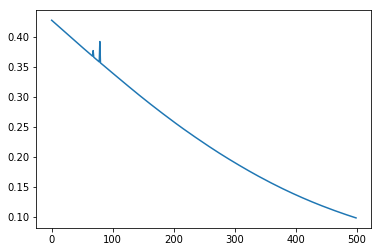

In [21]:
plt.plot(trainingLoss)

In [ ]:
#Things to do:
# 1. Fix Class imbalance in training set
# 2. Split Data into train/validation/test sets
# 3. Set up GPU usage
# 4. Create method to save model


In [26]:
pd.Series(Y.argmax(axis = 1)).value_counts()

1    2562
2     804
5     803
3     800
4     800
0      98
dtype: int64

In [ ]:
#The goal is to remove the labels with 0, and sample down the ones associated with 1 to 800.

In [ ]:
labelDictionay = {10:"start Block Event",
                 1 : "Rest Cue",
                 3: "Right Arm",
                 4: "Left Arm",
                 7: "Right Hand",
                 8: "Left Hand"}

In [ ]:
[10.0, 1.0, 7.0, 3.0, 8.0, 4.0]